In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
'''

#RECATEGORIZACIÓN: 1th method
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#RECATEGORIZACIÓN: 2nd method
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

#import matplotlib.pyplot as plt
#import matplotlib
#import seaborn as sns

import pathlib


# **> Opcion 1: DATOS PROCESADOS**

## Partimos de datos procesados por DE

In [12]:
'''
df_restaurants = pd.read_csv('../data_sources/raw data/restaurantes csv')
df_restaurants.head(2)
'''

"\ndf_restaurants = pd.read_csv('../data_sources/raw data/restaurantes csv')\ndf_restaurants.head(2)\n"

## Buscamos encontar relaciones entre variables que posteriormente podamos utilzar. De momento prescindimos de algunas, tales como:
- dirección: si bien las coordenadas son de utilidad (latitud y longitud)son de utilidad, en esta instancia la dirección es una etiqueta de ubicación menos valiosa para establecer una zona.
- condado
- código postal condado
- latitud condado
- longitud condado
- codigo postal ciudad
- estado: sabemos de antemano que vamos a analizar Florida unicamente, DE preparo los datos de antemano.
- url_del_negocio
-  enlaces_google_maps


# **> Opcion 2: DATOS EN BRUTO**

## Partimos de datos en bruto: archivos independientes unidos aqui.

In [4]:
# Getting the path with "pathlib" library
folder = pathlib.Path('../data_sources/raw data/restaurantes csv')
df_restaurants = pd.DataFrame() # Starting with a empty dataframe

for restaurant_file in folder.iterdir():

  df_to_concat = pd.read_csv(restaurant_file)
  df_restaurants = pd.concat([df_restaurants, df_to_concat])

df_restaurants.head(2)

,id_nombre,nombre,direccion,id_ciudad,ciudad,codigo_postal,latitud,longitud,puntuacion_yelp,categories,puntuacion_usuarios,anio,analisis_sentimientos,estado,pais
0,0018,Mr. Dunderbak's,14929 Bruce B Downs Blvd,RGTW,Tampa,33664,28.083089,-82.411907,4.5,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0,NaN,NaN
1,0040,Beef 'O' Brady's,10920 Cross Creek Blvd,RGTW,Tampa,33664,28.145413,-82.284034,2.0,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5,NaN,NaN


In [5]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46337 entries, 0 to 5042
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_nombre              46337 non-null  object 
 1   nombre                 45796 non-null  object 
 2   direccion              46077 non-null  object 
 3   id_ciudad              46337 non-null  object 
 4   ciudad                 46337 non-null  object 
 5   codigo_postal          46336 non-null  object 
 6   latitud                46337 non-null  float64
 7   longitud               46337 non-null  float64
 8   puntuacion_yelp        35497 non-null  float64
 9   categories             36636 non-null  object 
 10  puntuacion_usuarios    36636 non-null  float64
 11  anio                   46337 non-null  int64  
 12  analisis_sentimientos  36636 non-null  float64
 13  estado                 10840 non-null  object 
 14  pais                   9160 non-null   object 
dtypes: float

### Eliminamos atributos que no se consideran de valor para ésta etapa del análisis (considerando que luego se pueden integrar si resultan ser relevantes):

- direccion
- id_ciudad
- codigo_postal
- puntuacion_yelp
- estado
- pais

In [6]:
to_drop = ['direccion', 'id_ciudad', 'codigo_postal', 'puntuacion_yelp', 'estado', 'pais']
df_restaurants = df_restaurants.drop(to_drop, axis = 1)
df_restaurants.head(2)

,id_nombre,nombre,ciudad,latitud,longitud,categories,puntuacion_usuarios,anio,analisis_sentimientos
0,0018,Mr. Dunderbak's,Tampa,28.083089,-82.411907,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0
1,0040,Beef 'O' Brady's,Tampa,28.145413,-82.284034,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5


# **I) EDA**

### Exploramos los datos para ver la cantidad de información que tenemos:

In [7]:
print('La cantidad de ciudades presentes en el dataset es de: ' + str(df_restaurants['ciudad'].unique().shape[0]))

La cantidad de ciudades presentes en el dataset es de: 287


In [8]:
df_restaurants['ciudad'].value_counts() #[0:10,]

ciudad
Tampa                14497
San Petersburgo       3190
Clearwater            3158
Brandon               2086
Largo                 1353
                     ...  
Ponte Vedra Beach        1
Bartow                   1
Palm City                1
Winter Springs           1
Moore Haven              1
Name: count, Length: 287, dtype: int64

### Podría considerarse NO incluir a ciudades que no tengan una cantidad mínima de restaurantes (como aquellas que solo tienen 1 restaurante), pero de momento no se elimina bajo ese criterio.

### Existen files cuyo valor de atributos NO pueden ser nulos, ya que no aportan valor al análisis tales como:
- ciudad	
- latitud	
- longitud	
- categories	
- puntuacion_usuarios	
- anio

### Aquellas filas cuyo alguno de estos atributos sea NaN, se elimina:

In [19]:
percent = round(df_restaurants.dropna(subset = ['latitud', 'longitud', 'categories','puntuacion_usuarios', 'anio']).shape[0] / df_restaurants.shape[0], 2) *100
print('El porcentaje de datos resultantes luego del 1° filtro, es del:' + str(percent)+ ' %')

El porcentaje de datos resultantes luego del 1° filtro, es del:79.0 %


In [21]:
df_restaurants = df_restaurants.dropna(subset = ['latitud', 'longitud', 'categories','puntuacion_usuarios', 'anio'])
df_restaurants.head(2)

,id_nombre,nombre,ciudad,latitud,longitud,categories,puntuacion_usuarios,anio,analisis_sentimientos
0,0018,Mr. Dunderbak's,Tampa,28.083089,-82.411907,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0
1,0040,Beef 'O' Brady's,Tampa,28.145413,-82.284034,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5


### Se crea un nuevo atributo "buena_puntuacion": definida como aquella que posee una puntuación de usuario mayor o igual a 4.

In [ ]:
df_restaurants['buena_puntuacion'] = df_restaurants['puntuacion_usuarios'].apply(lambda x: (x >= 4))
df_restaurants.head(2)

,id_nombre,nombre,ciudad,latitud,longitud,categories,puntuacion_usuarios,anio,analisis_sentimientos,buena_puntuacion
0,0018,Mr. Dunderbak's,Tampa,28.083089,-82.411907,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0,True
1,0040,Beef 'O' Brady's,Tampa,28.145413,-82.284034,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5,False


In [35]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36636 entries, 0 to 1138
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_nombre              36636 non-null  object 
 1   nombre                 36636 non-null  object 
 2   ciudad                 36636 non-null  object 
 3   latitud                36636 non-null  float64
 4   longitud               36636 non-null  float64
 5   categories             36636 non-null  object 
 6   puntuacion_usuarios    36636 non-null  float64
 7   anio                   36636 non-null  int64  
 8   analisis_sentimientos  36636 non-null  float64
 9   buena_puntuacion       36636 non-null  bool   
dtypes: bool(1), float64(4), int64(1), object(4)
memory usage: 3.8+ MB


# **I.1) KPI1**: % de buenas puntuaciones
### Creamos una df que contenga la información necesaria en el formato correcto para poder obtener un datatime, según ciudad:

In [85]:
kpi1_dict = {} # Empty dictionary
cities = df_restaurants['ciudad'].unique() # Lista con las ciudades seleccionadas
anios = df_restaurants['anio'].sort_values().unique() # Lista con los años de los cuales disponemos de datos

for city in cities:

  kpi1 = df_restaurants[(df_restaurants['ciudad'] == city)]
  kpi1_lista = []
  
  for anio in anios:

    num = np.shape(kpi1[(kpi1['anio'] == anio) & kpi1['buena_puntuacion'] == True])[0]
    den = np.shape(kpi1[kpi1['anio'] == anio])[0]

    if den != 0:
      ratio = round((num/den)*100, 1)

    else:
      ratio = np.nan

    kpi1_lista.append(ratio)

  kpi1_dict[city] = kpi1_lista

kpi1_df = pd.DataFrame(kpi1_dict, index = anios)
kpi1_df

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,...,Hobe Sound,Williston,Summerfield,North Fort Myers,Interlachen,Daytona Beach Shores,Bainbridge,Chipley,Montverde,Marianna
2006,66.0,28.6,76.9,50.0,54.5,100.0,50.0,50.0,57.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,66.7,62.5,68.2,100.0,75.0,100.0,100.0,100.0,66.7,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,57.1,61.5,58.0,66.7,57.1,0.0,71.4,100.0,54.5,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,50.7,34.9,59.3,50.0,50.0,44.4,41.7,66.7,70.6,63.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,51.1,41.4,50.5,43.5,46.4,68.8,41.7,55.2,57.9,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,43.3,40.7,53.8,26.7,28.6,57.6,46.2,66.7,54.8,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,41.2,51.8,46.0,37.1,27.3,57.1,28.6,44.1,48.6,48.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,41.7,38.1,42.0,20.8,29.3,52.9,61.9,42.3,39.7,44.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,43.4,37.7,47.7,30.4,22.7,58.3,44.4,40.3,41.1,41.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,49.0,46.4,50.0,28.6,33.3,43.1,54.2,47.0,44.0,43.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Eliminaremos:
- Registros del 2024
- Registros que con al menos algún valor NaN

In [86]:
kpi1_df = kpi1_df.drop(index = [2024]) # borrando registros del 2024
kpi1_df = kpi1_df.dropna(how = 'any', axis = 1)
kpi1_df

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,Pinellas Park,Largo,Oldsmar,Indian Rocks Beach,Tarpon Springs,San Petersburgo
2006,66.0,28.6,76.9,50.0,54.5,100.0,50.0,50.0,57.1,0.0,100.0,40.0,0.0,100.0,50.0,83.3
2007,66.7,62.5,68.2,100.0,75.0,100.0,100.0,100.0,66.7,100.0,100.0,100.0,66.7,100.0,50.0,52.2
2008,57.1,61.5,58.0,66.7,57.1,0.0,71.4,100.0,54.5,50.0,37.5,75.0,25.0,83.3,70.0,57.4
2009,50.7,34.9,59.3,50.0,50.0,44.4,41.7,66.7,70.6,63.6,62.5,63.6,40.0,72.7,58.8,48.8
2010,51.1,41.4,50.5,43.5,46.4,68.8,41.7,55.2,57.9,50.0,55.2,64.1,50.0,47.1,60.9,45.5
2011,43.3,40.7,53.8,26.7,28.6,57.6,46.2,66.7,54.8,40.0,48.6,64.9,36.4,44.4,50.0,46.6
2012,41.2,51.8,46.0,37.1,27.3,57.1,28.6,44.1,48.6,48.6,47.1,47.8,33.3,38.1,64.4,50.7
2013,41.7,38.1,42.0,20.8,29.3,52.9,61.9,42.3,39.7,44.7,47.2,44.7,33.3,45.5,47.3,42.9
2014,43.4,37.7,47.7,30.4,22.7,58.3,44.4,40.3,41.1,41.7,49.2,53.2,33.3,48.3,53.7,44.1
2015,49.0,46.4,50.0,28.6,33.3,43.1,54.2,47.0,44.0,43.9,49.2,45.9,50.0,46.4,59.2,49.3


## **Grafico 1:** comportamiento a lo largo del tiempo
### > Se consideran los valores del 2006 al 2022
### > Solo ciudades que no contengan valores nulos

<Axes: >

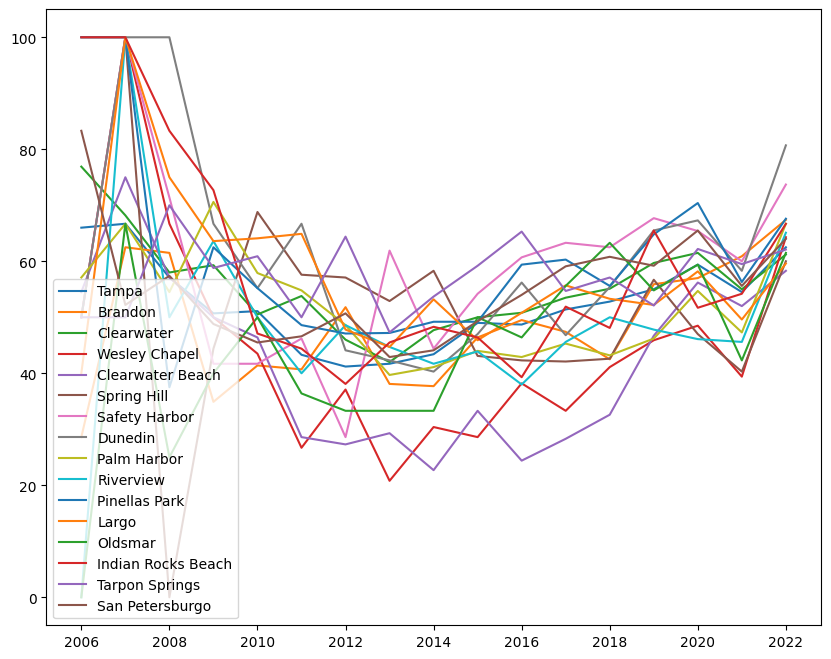

In [87]:
kpi1_df.plot(figsize=(10,8))

## **Grafico 2:** diagramas de caja

In [110]:
kpi1_df.transpose()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Tampa,66.0,66.7,57.1,50.7,51.1,43.3,41.2,41.7,43.4,49.0,48.7,51.4,52.8,55.0,59.4,54.5,62.5
Brandon,28.6,62.5,61.5,34.9,41.4,40.7,51.8,38.1,37.7,46.4,49.5,47.4,42.5,55.9,57.0,60.9,67.4
Clearwater,76.9,68.2,58.0,59.3,50.5,53.8,46.0,42.0,47.7,50.0,50.8,53.5,55.1,59.7,61.5,55.0,61.2
Wesley Chapel,50.0,100.0,66.7,50.0,43.5,26.7,37.1,20.8,30.4,28.6,38.2,33.3,41.1,45.9,48.5,39.4,64.3
Clearwater Beach,54.5,75.0,57.1,50.0,46.4,28.6,27.3,29.3,22.7,33.3,24.4,28.3,32.6,46.7,56.2,52.0,58.3
Spring Hill,100.0,100.0,0.0,44.4,68.8,57.6,57.1,52.9,58.3,43.1,42.3,42.1,42.6,56.7,47.0,40.3,60.0
Safety Harbor,50.0,100.0,71.4,41.7,41.7,46.2,28.6,61.9,44.4,54.2,60.7,63.3,62.5,67.7,65.4,60.0,73.7
Dunedin,50.0,100.0,100.0,66.7,55.2,66.7,44.1,42.3,40.3,47.0,56.2,46.8,55.4,65.5,67.3,58.3,80.7
Palm Harbor,57.1,66.7,54.5,70.6,57.9,54.8,48.6,39.7,41.1,44.0,42.9,45.3,43.2,46.2,54.7,47.3,66.7
Riverview,0.0,100.0,50.0,63.6,50.0,40.0,48.6,44.7,41.7,43.9,38.0,45.6,50.0,47.8,46.1,45.6,65.1


<Axes: >

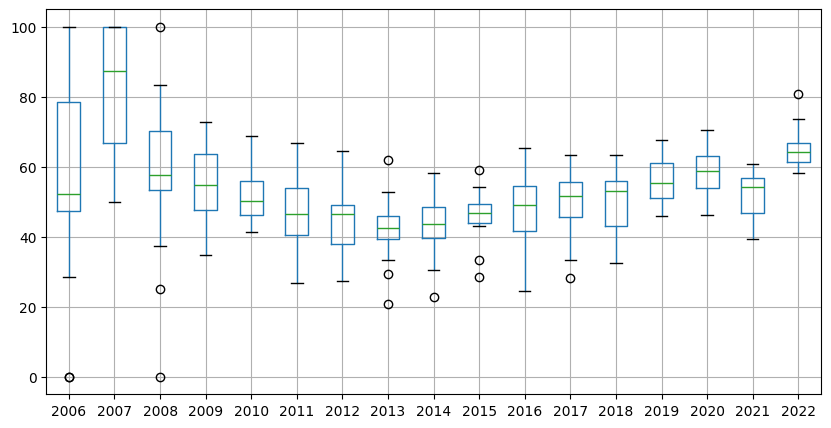

In [112]:
kpi1_df.transpose().boxplot(figsize=(10,5))

### Para obtener un valor representativo de la tendencia actual, elegimos la media correspondiente al año 2022:

In [88]:
kpi1_df.iloc[-1:,:]

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,Pinellas Park,Largo,Oldsmar,Indian Rocks Beach,Tarpon Springs,San Petersburgo
2022,62.5,67.4,61.2,64.3,58.3,60.0,73.7,80.7,66.7,65.1,67.6,59.6,61.5,66.7,62.1,64.0


In [91]:
kpi1_trend = round(np.mean(kpi1_df.iloc[-1:,:]), 1)
print('La media de buenas puntuaciones para el año 2022 es de: ' + str(kpi1_trend) + ' %')

La media de buenas puntuaciones para el año 2022 es de: 65.1 %


## **Conclusiones (I.1)**
### De la gráfica y las métricas, puede verse que:

### a) El % de buenas puntuaciones tiende tendencia creciente independientemente de la ciudad elegida.
### b) Independientemente de la ciudad: la tendecia es similar

### Benchmarking: es importante entender que si se busca presencia en este mercado, es importante apuntar a la métrica obtenida, la media del ultimo año, el 65%, esto es lo que conforma nuestro **KPI1**.

In [93]:
kpi1_df.to_csv('results_kpi1.csv')

---------------------


## **I.2) KPI2**: puntuación clientes

### Analicemos el comportamiento de la puntuación de los clientes a lo largo del tiempo

In [102]:
kpi2_dict = {} # Empty dictionary
cities = df_restaurants['ciudad'].unique() # Lista con las ciudades seleccionadas
anios = df_restaurants['anio'].sort_values().unique() # Lista con los años de los cuales disponemos de datos

for city in cities:

  kpi2 = df_restaurants[(df_restaurants['ciudad'] == city)]
  kpi2_lista = []
  for anio in anios:

    average_stars = round(kpi2['puntuacion_usuarios'][kpi2['anio'] == anio].mean(), 2)
    kpi2_lista.append(average_stars)

  kpi2_dict[city] = kpi2_lista

kpi2_df = pd.DataFrame(kpi2_dict, index = anios)
kpi2_df

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,...,Hobe Sound,Williston,Summerfield,North Fort Myers,Interlachen,Daytona Beach Shores,Bainbridge,Chipley,Montverde,Marianna
2006,3.87,3.04,3.87,3.50,3.86,5.00,3.50,3.50,3.74,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,3.92,3.31,3.94,4.00,4.03,4.00,4.50,4.50,3.67,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,3.77,3.68,3.87,3.70,3.79,3.00,3.86,4.44,3.45,3.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,3.71,3.36,3.70,3.90,3.47,3.69,3.35,3.72,3.87,3.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,3.73,3.63,3.61,3.52,3.45,4.03,3.22,3.85,3.84,3.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,3.64,3.53,3.74,3.36,3.38,3.77,3.57,4.01,3.81,3.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,3.64,3.65,3.70,3.40,3.45,3.77,3.58,3.57,3.69,3.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,3.66,3.55,3.70,3.29,3.56,3.85,3.88,3.65,3.64,3.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,3.66,3.66,3.71,3.44,3.45,3.97,3.60,3.71,3.74,3.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,3.72,3.65,3.78,3.49,3.60,3.59,3.96,3.78,3.79,3.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Eliminaremos:
- Columnas donde todos los valores sean NaN

In [104]:
kpi2_df = kpi2_df.dropna(how = 'any', axis = 1)
kpi2_df

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,Pinellas Park,Largo,Oldsmar,Indian Rocks Beach,Tarpon Springs
2006,3.87,3.04,3.87,3.50,3.86,5.00,3.50,3.50,3.74,1.00,5.00,2.30,3.00,4.62,3.38
2007,3.92,3.31,3.94,4.00,4.03,4.00,4.50,4.50,3.67,5.00,5.00,4.00,4.17,4.50,3.50
2008,3.77,3.68,3.87,3.70,3.79,3.00,3.86,4.44,3.45,3.75,3.50,3.83,3.35,4.41,3.93
2009,3.71,3.36,3.70,3.90,3.47,3.69,3.35,3.72,3.87,3.76,3.78,3.80,3.10,4.13,3.60
2010,3.73,3.63,3.61,3.52,3.45,4.03,3.22,3.85,3.84,3.43,3.85,3.71,3.88,3.71,3.82
2011,3.64,3.53,3.74,3.36,3.38,3.77,3.57,4.01,3.81,3.86,3.70,3.91,3.57,3.61,3.77
2012,3.64,3.65,3.70,3.40,3.45,3.77,3.58,3.57,3.69,3.58,3.60,3.64,3.52,3.68,3.95
2013,3.66,3.55,3.70,3.29,3.56,3.85,3.88,3.65,3.64,3.79,3.59,3.71,3.51,3.59,3.66
2014,3.66,3.66,3.71,3.44,3.45,3.97,3.60,3.71,3.74,3.57,3.69,3.86,3.54,3.74,3.77
2015,3.72,3.65,3.78,3.49,3.60,3.59,3.96,3.78,3.79,3.68,3.70,3.75,3.70,3.85,3.98


### El df contiene el promedio de las puntuaciones de los restaurantes de esa ciudad a lo largo del tiempo: 
### **un registro de promedios**. Analizaremos su comportamiento.

## **Grafico 1:** comportamiento a lo largo del tiempo

<Axes: >

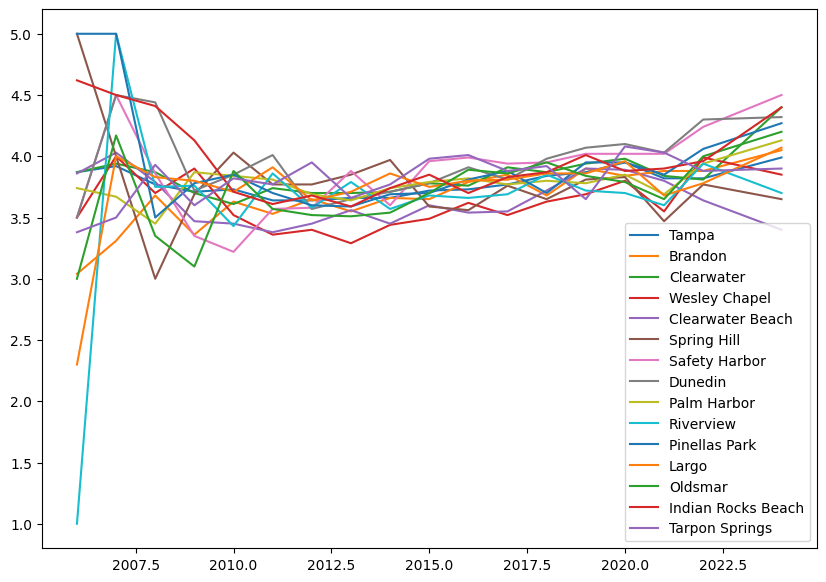

In [164]:
kpi2_df.plot(figsize=(10,7))

## **Grafico 2:** diagramas de caja

In [106]:
kpi2_df.transpose()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2024
Tampa,3.87,3.92,3.77,3.71,3.73,3.64,3.64,3.66,3.66,3.72,3.73,3.77,3.84,3.87,3.95,3.82,3.82,3.99
Brandon,3.04,3.31,3.68,3.36,3.63,3.53,3.65,3.55,3.66,3.65,3.79,3.85,3.68,3.90,3.84,3.88,3.88,4.05
Clearwater,3.87,3.94,3.87,3.70,3.61,3.74,3.70,3.70,3.71,3.78,3.76,3.91,3.87,3.94,3.98,3.84,3.81,4.40
Wesley Chapel,3.50,4.00,3.70,3.90,3.52,3.36,3.40,3.29,3.44,3.49,3.62,3.52,3.63,3.69,3.80,3.55,3.99,3.85
Clearwater Beach,3.86,4.03,3.79,3.47,3.45,3.38,3.45,3.56,3.45,3.60,3.54,3.55,3.72,3.90,3.89,3.80,3.64,3.40
Spring Hill,5.00,4.00,3.00,3.69,4.03,3.77,3.77,3.85,3.97,3.59,3.56,3.76,3.65,3.81,3.83,3.47,3.77,3.65
Safety Harbor,3.50,4.50,3.86,3.35,3.22,3.57,3.58,3.88,3.60,3.96,3.99,3.94,3.95,4.02,4.02,4.02,4.24,4.50
Dunedin,3.50,4.50,4.44,3.72,3.85,4.01,3.57,3.65,3.71,3.78,3.91,3.81,3.98,4.07,4.10,4.03,4.30,4.32
Palm Harbor,3.74,3.67,3.45,3.87,3.84,3.81,3.69,3.64,3.74,3.79,3.82,3.77,3.80,3.78,3.85,3.69,3.94,4.13
Riverview,1.00,5.00,3.75,3.76,3.43,3.86,3.58,3.79,3.57,3.68,3.66,3.69,3.85,3.72,3.70,3.60,3.94,3.70


(2.0, 5.2)

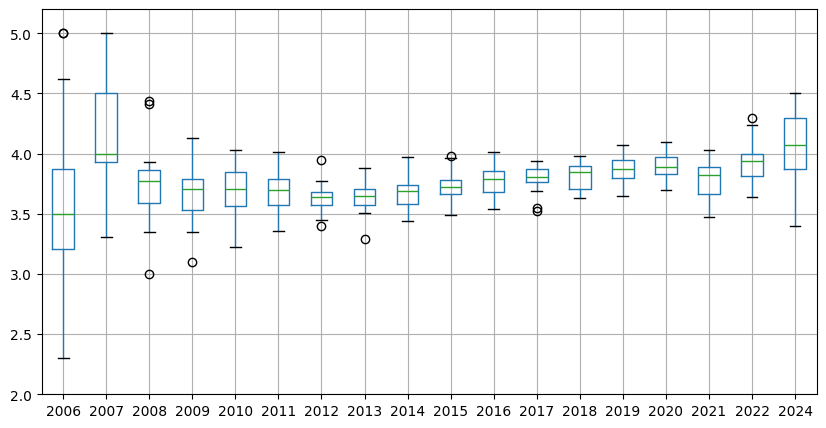

In [166]:
kpi2_df.transpose().boxplot(figsize=(10,5))
plt.ylim(2,)

### Para obtener un valor representativo de la tendencia actual, elegimos la media correspondiente al año 2024:

In [113]:
kpi2_df.iloc[-1:,:]

,Tampa,Brandon,Clearwater,Wesley Chapel,Clearwater Beach,Spring Hill,Safety Harbor,Dunedin,Palm Harbor,Riverview,Pinellas Park,Largo,Oldsmar,Indian Rocks Beach,Tarpon Springs
2024,3.99,4.05,4.4,3.85,3.4,3.65,4.5,4.32,4.13,3.7,4.27,4.07,4.2,4.4,3.9


In [115]:
kpi2_trend = round(np.mean(kpi2_df.iloc[-1:,:]), 1)
print('La media de puntuaciones para el año 2024 fue de: ' + str(kpi2_trend))

La media de puntuaciones para el año 2024 fue de: 4.1


## **Conclusiones (I.2)**
### De la gráfica y las métricas, puede verse que:

### a) A los largo del tiempo, la media se mueve entre 3.5 y 4.0
### b) Independientemente de la ciudad: hay una tendencia similar a ubicarse en esa banda

### Benchmarking: es importante entender que si se busca presencia en este mercado, es importante apuntar a una métrica, la media del ultimo año, el 4.1, esto es lo que conforma nuestro **KPI2**.

In [ ]:
kpi2_df.to_csv('results_kpi2.csv')

-----------------------

## **I.3) KPI3**

-----------------------

# **II) Consulta del PO:**

## *¿Cuáles son las ciudades con mejores puntuaciones, pero pocos restaurantes?*

In [117]:
df_restaurants.head(2)

,id_nombre,nombre,ciudad,latitud,longitud,categories,puntuacion_usuarios,anio,analisis_sentimientos,buena_puntuacion
0,0018,Mr. Dunderbak's,Tampa,28.083089,-82.411907,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0,True
1,0040,Beef 'O' Brady's,Tampa,28.145413,-82.284034,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5,False


In [119]:
subset_df = df_restaurants[['nombre', 'ciudad', 'puntuacion_usuarios', 'anio']][df_restaurants['buena_puntuacion'] == True]
subset_df

,nombre,ciudad,puntuacion_usuarios,anio
0,Mr. Dunderbak's,Tampa,5.0,2006
3,Oasis Bakery & Middle Eastern Foods,Tampa,4.0,2006
6,Mario's Pizza,Clearwater,4.0,2006
7,Oystercatchers,Tampa,4.7,2006
8,Estela's Mexican Restaurant,Tampa,5.0,2006
...,...,...,...,...
1132,Zona Fresca,Fort Lauderdale,4.6,2024
1133,Zoës Kitchen,Tallahassee,4.6,2024
1134,Zoës Kitchen,Pensacola,4.3,2024
1135,bp,Miami,4.0,2024


### Necesitamos crear un df que contenga la cantidad de restaurantes por ciudad a lo largo del tiempo

In [137]:
restaurants_bycity_byyear = {} # Empty dictionary
cities = subset_df['ciudad'].value_counts().index # Lista con las ciudades seleccionadas
anios = subset_df['anio'].sort_values().unique() # Lista con los años de los cuales disponemos de datos

for city in cities:

  po_df_bycity= subset_df[subset_df['ciudad'] == city]
  values_bycity_byyear = []

  for anio in anios:

    po_bycity_byyear = po_df_bycity[po_df_bycity['anio'] == anio]
    number_restaurants = np.shape(po_bycity_byyear)[0]
    values_bycity_byyear.append(number_restaurants)

  restaurants_bycity_byyear[city] = values_bycity_byyear

po_df = pd.DataFrame(restaurants_bycity_byyear, index = anios)
po_df

,Tampa,Clearwater,San Petersburgo,Largo,Brandon,Dunedin,New Port Richey,Palm Harbor,Tarpon Springs,Pinellas Park,...,Neptune Beach,Wildwood,Niceville,Pace,Bell,Oviedo,Madeira Beach,Wilton Manors,Baker,Cooper City
2006,128,40,10,4,4,4,2,16,4,2,...,0,0,0,0,0,0,0,0,0,0
2007,86,15,12,1,5,1,0,2,3,1,...,0,0,0,0,0,0,0,0,0,0
2008,137,29,39,18,8,8,5,6,7,3,...,0,0,0,0,0,0,0,0,0,0
2009,203,48,42,14,15,10,7,12,10,10,...,0,0,0,0,0,0,0,0,0,0
2010,272,52,45,25,24,16,17,22,14,16,...,0,0,0,0,0,0,0,0,0,0
2011,306,77,62,37,33,28,29,34,17,18,...,0,0,0,0,0,0,0,0,0,0
2012,344,80,76,33,43,30,27,34,29,24,...,0,0,0,0,0,0,0,0,0,0
2013,399,87,67,38,37,30,38,31,26,25,...,0,0,0,0,0,0,0,0,0,0
2014,461,113,71,50,40,29,44,30,36,29,...,0,0,0,0,0,0,0,0,0,0
2015,567,125,102,50,45,39,49,37,42,31,...,0,0,0,0,0,0,0,0,0,0


### Eliminaremos:
- Columnas donde algún valor sea 0
- Datos del 2024

In [138]:
po_df = po_df.iloc[:-1,:]  # Exclude the 2024 values
po_df = po_df.replace(0, np.nan).dropna(axis=1, how="any") #Deleting columns that contains at least "0"
po_df

,Tampa,Clearwater,San Petersburgo,Largo,Brandon,Dunedin,Palm Harbor,Tarpon Springs,Pinellas Park,Wesley Chapel,Clearwater Beach,Safety Harbor,Indian Rocks Beach
2006,128,40,10,4,4,4,16,4,2,6,12,2,8
2007,86,15,12,1,5,1,2,3,1,2,6,3,2
2008,137,29,39,18,8,8,6,7,3,4,8,5,10
2009,203,48,42,14,15,10,12,10,10,3,9,5,8
2010,272,52,45,25,24,16,22,14,16,10,13,5,8
2011,306,77,62,37,33,28,34,17,18,8,10,6,8
2012,344,80,76,33,43,30,34,29,24,13,9,6,8
2013,399,87,67,38,37,30,31,26,25,10,12,13,10
2014,461,113,71,50,40,29,30,36,29,14,10,12,14
2015,567,125,102,50,45,39,37,42,31,14,14,13,13


### El df contiene la cantidad de restaurantes con buena puntuacion (mayor o igual a 4) por ciudad, por año.

## **Graficando:** cantidad de restaurantes

<Axes: >

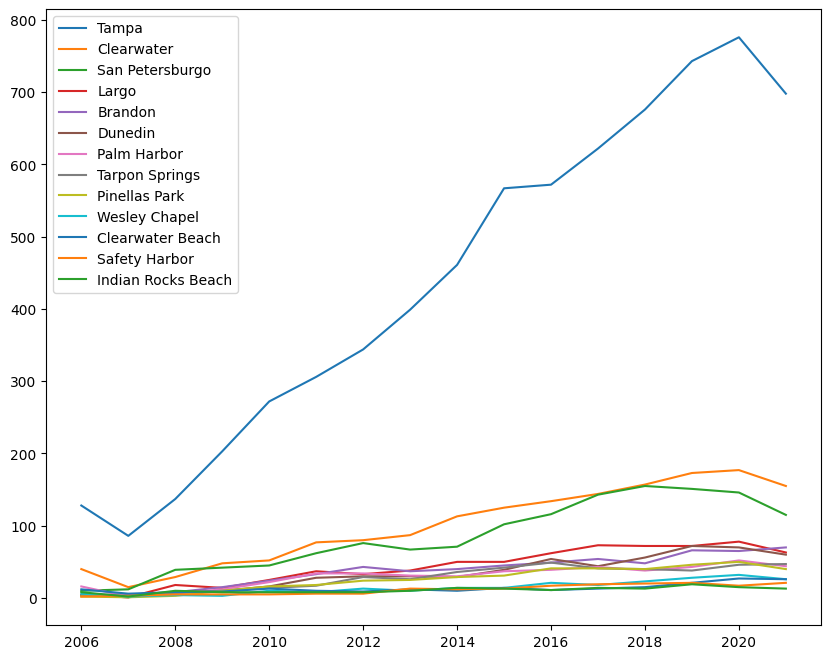

In [ ]:
po_df.plot(figsize=(10,8))

### Dada la gran diferencia entre cantidad x ciudad, para hacer una comparación justa, se va a comparar el incremmento relativo en las ciudades. Siendo asi, podremos ver la evolución  de la cantidad de restaurantes (buenos) en terminos relativos.

In [151]:
po2_dict = {} # Empty dictionary
cities = po_df.columns # Lista de ciudades
anios = po_df.index[1:] # Lista con los años de los que se cuenta con información

for city in cities:

  ai = np.array(po_df[city].iloc[:-1])
  aiplus = np.array(po_df[city].iloc[1:])

  ratio_bycity =  ((aiplus - ai) / ai) * 100
  po2_dict[city] = ratio_bycity

po2_df = pd.DataFrame(po2_dict, index = anios)
po2_df = round(po2_df, 1)
po2_df

,Tampa,Clearwater,San Petersburgo,Largo,Brandon,Dunedin,Palm Harbor,Tarpon Springs,Pinellas Park,Wesley Chapel,Clearwater Beach,Safety Harbor,Indian Rocks Beach
2007,-32.8,-62.5,20.0,-75.0,25.0,-75.0,-87.5,-25.0,-50.0,-66.7,-50.0,50.0,-75.0
2008,59.3,93.3,225.0,1700.0,60.0,700.0,200.0,133.3,200.0,100.0,33.3,66.7,400.0
2009,48.2,65.5,7.7,-22.2,87.5,25.0,100.0,42.9,233.3,-25.0,12.5,0.0,-20.0
2010,34.0,8.3,7.1,78.6,60.0,60.0,83.3,40.0,60.0,233.3,44.4,0.0,0.0
2011,12.5,48.1,37.8,48.0,37.5,75.0,54.5,21.4,12.5,-20.0,-23.1,20.0,0.0
2012,12.4,3.9,22.6,-10.8,30.3,7.1,0.0,70.6,33.3,62.5,-10.0,0.0,0.0
2013,16.0,8.8,-11.8,15.2,-14.0,0.0,-8.8,-10.3,4.2,-23.1,33.3,116.7,25.0
2014,15.5,29.9,6.0,31.6,8.1,-3.3,-3.2,38.5,16.0,40.0,-16.7,-7.7,40.0
2015,23.0,10.6,43.7,0.0,12.5,34.5,23.3,16.7,6.9,0.0,40.0,8.3,-7.1
2016,0.9,7.2,13.7,24.0,8.9,38.5,5.4,16.7,32.3,50.0,-21.4,30.8,-15.4


(-200.0, 200.0)

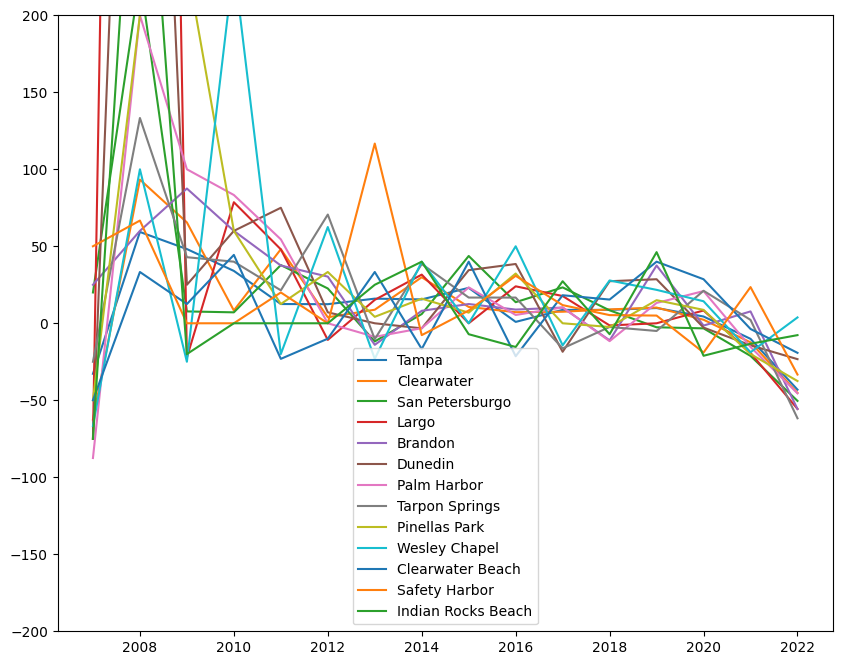

In [155]:
po2_df.plot(figsize=(10,8))
plt.ylim(-200, 200)

(-100.0, 400.0)

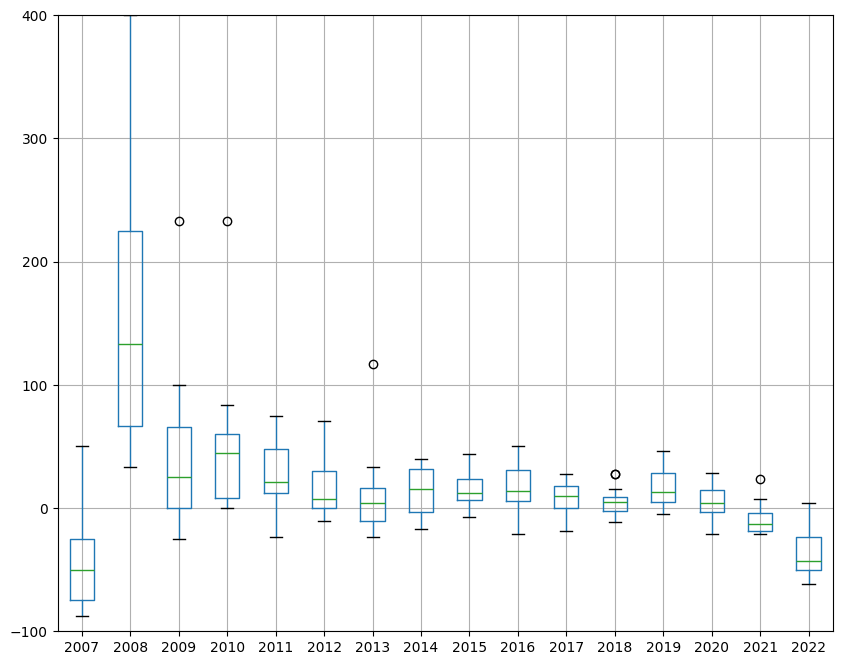

In [162]:
po2_df.transpose().boxplot(figsize=(10,8))
plt.ylim(-100, 400)

---------------------

# **III) RECATEGORIZACIÓN**

In [168]:
## Borramos aquellos filas con valores que requerimos que NO sean nulos:
df_restaurants = df_restaurants.dropna(subset = ['latitud', 'longitud', 'categories','puntuacion_usuarios', 'anio'])
df_restaurants.head(2)

,id_nombre,nombre,ciudad,latitud,longitud,categories,puntuacion_usuarios,anio,analisis_sentimientos,buena_puntuacion
0,0018,Mr. Dunderbak's,Tampa,28.083089,-82.411907,"Beer, Wine & Spirits, Food, Pubs, German, Amer...",5.0,2006,1.0,True
1,0040,Beef 'O' Brady's,Tampa,28.145413,-82.284034,"Sports Bars, Fast Food, Bars, American (Tradit...",2.0,2006,0.5,False


In [172]:
print(df_restaurants['categories'].unique())
print('')
print('En el estado actual la cantidad de categorias es: '+ str(df_restaurants['categories'].unique().shape[0]))

['Beer, Wine & Spirits, Food, Pubs, German, American (Traditional), Restaurants, Bars, Nightlife'
 'Sports Bars, Fast Food, Bars, American (Traditional), Pubs, Restaurants, Nightlife'
 'Restaurants, Pizza, American (Traditional)' ...
 'Mediterranean restaurant, American restaurant, Greek restaurant, Italian restaurant, Restaurant, Seafood restaurant, Steak house'
 'Mediterranean restaurant, Caterer, Restaurant'
 'Gas station, ATM, Restaurant']

En el estado actual la cantidad de categorias es: 4999


### Se ve que existen unas 5000 categorias, para poder reducir esto, debemos encontrar la manera de recategorizar los restaurantes.
### Primero, vemos cuantas categorias individuales hay en el dataset:

In [173]:
# Creamos un string que contenga todas las categorias: estén repetidas o no:
rows = df_restaurants.shape[0]
i = 0
categories = ''

while i < rows:

  categories = categories + ',' + df_restaurants['categories'].iloc[i]
  i += 1

#Convertir el string en una lista:
list_categories = categories.split(",")

#Convertir lista en set:
set_categories = set(list_categories) # Contiene elementos únicos
print('Hay un total de: ' + str(len(set_categories)) + ' categorias únicas')

Hay un total de: 951 categorias únicas


### III.1) RECATEGORIZACIÓN POR: **TF-IDF y KMeans**



In [174]:
# Ejemplo de categorías como descripciones de texto
categorias = list(set_categories)

# Convertir las categorías a una representación TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(categorias)

# Aplicar KMeans para reducir a 30 grupos
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(X)

# Mostrar las categorías y sus grupos asignados
resultado_TF = pd.DataFrame({'Categoria': categorias, 'Categoria Principal': kmeans.labels_})

In [176]:
resultado_TF[resultado_TF['Categoria Principal'] == 10]

,Categoria,Categoria Principal
84,Espresso bar,10
101,Bar Crawl,10
193,Cocktail bar,10
260,Bar,10
268,Sports bar,10
301,Tapas bar,10
394,Sports bar,10
521,Wine bar,10
550,Live music bar,10
618,Wine bar,10


### III.2) RECATEGORIZACIÓN POR: **Word2Vec y KMeans**

In [178]:
# Ejemplo de datos de categorías (estas serían las etiquetas o categorías)
categorias = list(set_categories)

# Entrenar un modelo Word2Vec para las categorías (en este caso, las categorías son palabras, pero podrían ser expresiones más complejas)
model = Word2Vec([categorias], vector_size=10, window=5, min_count=1, workers=4)

# Obtener las representaciones vectoriales de las categorías
vector_categorias = [model.wv[categoria] for categoria in categorias]

# Aplicar KMeans para reducir las categorías a 30 grupos
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(vector_categorias)

# Mostrar los grupos de categorías
resultado_WV = pd.DataFrame({'Categoria': categorias, 'Categoria Principal': kmeans.labels_})

In [179]:
resultado_WV[resultado_WV['Categoria Principal'] == 10]

,Categoria,Categoria Principal
24,Greek restaurant,10
43,Belgian,10
55,Dominican,10
69,Divorce & Family Law,10
97,Argentinian restaurant,10
114,Cultural Center,10
127,Cuban restaurant,10
149,Wine & Spirits,10
176,Resorts,10
201,South Asian restaurant,10


### Se opta por el método N°1 primer(**TF-IDF y KMeans**):
### > Lo convertimos en un diccionario:
### > Se reemplazan las categorias originales por las categorias principales encontradas

In [180]:
# Dictionary with the main categories
dict_main_cat = {}
main_cat = resultado_TF['Categoria Principal'].sort_values().unique() # Numbers from 0 to 29 (30 categorias)

for m in main_cat:

  dict_main_cat[m] = set(resultado_TF[resultado_TF['Categoria Principal'] == m]['Categoria'])

In [77]:
rows = df_restaurants.shape[0]

for r in rows:

  numeric_rest_cat = []
  rest_cat = set(df_restaurants['categories'].iloc[r].split(','))

  for m in main_cat:

    value = bool(rest_cat.intersection( dict_main_cat[m]))

    if value:

      numeric_rest_cat.append(m)

  df_restaurants['categories'].iloc[r] = numeric_rest_cat


TypeError: 'int' object is not iterable

___________________________________